<a href="https://colab.research.google.com/github/thalesdaviddom/IC-Lorena-Chico/blob/main/TFMN_first_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we expect to take a first look at our TFMNs, for this we are merging all of them in convenient groups like Language, Countries, Journals and etc according to the original dataset.

First we load the dataset:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Material_IC/Corpus/Artigos/dataset de trabalho/dataset.csv')
df.head()

,Unnamed: 0,Title,DOI,PDF Name,OpenAlex_id,Year,Source Title,Abstract,Author Keywords,Language of Original Document,Journal Country
0,0,Fighting for the True Path of Revolution: The ...,10.1177/0094582x241300288,Fighting-for-the-True-Path-of-Revolution-The-C...,https://openalex.org/W4405262715,2024,Latin American Perspectives,The Salvadoran Communist Party (PCS) underwent...,El Salvador; Latin American Communism; Revolut...,English,United States
1,1,Media representations of the Chilean press on ...,10.35956/v.24.n1.2024.p.66-85,Media-representations-of-the-Chilean-press-on-...,https://openalex.org/W4401198837,2024,Latin-American Journal of Discourse Studies,The study analyses media representations of th...,Chilean constitutional process; Critical Disco...,Spanish,Brazil
2,2,Autonomies and the Construction of Communal Ec...,10.1177/0094582x241297919,Autonomies-and-the-Construction-of-Communal-Ec...,https://openalex.org/W4404511688,2024,Latin American Perspectives,"San José, a Zapotec community in the Sierra Su...",Communal autonomies; Communal economies; Commu...,English,United States
3,3,Income Protection for Vulnerable Groups During...,10.1177/0094582x241308856,Income-Protection-for-Vulnerable-Groups-During...,https://openalex.org/W4406033597,2025,Latin American Perspectives,How can we understand the variation in countri...,Brazil; Chile; COVID-19; Emergency measures; I...,English,United States
4,4,Partisan Stereotyping and Polarization in Brazil,10.1017/lap.2023.38,Partisan-Stereotyping-and-Polarization-in-Braz...,https://openalex.org/W4389787718,2024,Latin American Politics and Society,"In recent decades, Brazilian voters have grown...",antipetismo; Brazil; negative partisanship; pa...,English,United States


The first thing we are trying is to merge all the TFMN into one and see its properties:

In [17]:
!pip install igraph

In [22]:
import os
from glob import glob
from igraph import Graph

def combine_edge_files(input_dir, output_file):
    """
    Combine all edge list files in a directory into one consolidated file.

    Args:
        input_dir: Directory containing edge list files
        output_file: Path for the combined output file
    """
    # Initialize data structures to hold combined edges
    synonyms = set()
    syntactic = set()
    hypernyms = set()

    # Process each file in the directory
    for file_path in glob(os.path.join(input_dir, '*_edges_list.txt')):
        current_section = None

        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()

                # Detect section headers
                if line.endswith(':'):
                    current_section = line[:-1].lower()
                    continue

                # Process edges based on current section
                if current_section and line.startswith('(') and line.endswith(')'):
                    edge = line[1:-1].replace("'", "").split(', ')
                    if len(edge) == 2:
                        u, v = edge[0].strip(), edge[1].strip()
                        edge_tuple = (u, v)

                        # Add to appropriate section
                        if current_section == 'synonyms':
                            synonyms.add(edge_tuple)
                        elif current_section == 'syntactic':
                            syntactic.add(edge_tuple)
                        elif current_section == 'hypernyms':
                            hypernyms.add(edge_tuple)

    # Write combined edges to output file
    with open(output_file, 'w', encoding='utf-8') as f_out:
        # Write synonyms section
        f_out.write("Synonyms:\n")
        for edge in sorted(synonyms):
            f_out.write(f"('{edge[0]}', '{edge[1]}')\n")

        # Write syntactic section
        f_out.write("\nSyntactic:\n")
        for edge in sorted(syntactic):
            f_out.write(f"('{edge[0]}', '{edge[1]}')\n")

        # Write hypernyms section
        f_out.write("\nHypernyms:\n")
        for edge in sorted(hypernyms):
            f_out.write(f"('{edge[0]}', '{edge[1]}')\n")

def create_graph_from_combined_file(combined_file):
    """
    Create an igraph Graph object from the combined edge file.

    Args:
        combined_file: Path to the combined edge file

    Returns:
        igraph.Graph object
    """
    edges = []
    edge_types = []
    current_section = None

    with open(combined_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            if line.endswith(':'):
                current_section = line[:-1].lower()
            elif current_section and line.startswith('(') and line.endswith(')'):
                edge = line[1:-1].replace("'", "").split(', ')
                if len(edge) == 2:
                    edges.append((edge[0].strip(), edge[1].strip()))
                    edge_types.append(current_section)

    # Create graph with edge types
    if edges:
        g = Graph.TupleList(edges, directed=False, edge_attrs={'type': edge_types})
        return g
    return Graph()

def main():
    # Configuration
    input_directory = '/content/drive/MyDrive/Material_IC/Corpus/Artigos/TFMN'  # Replace with your directory
    combined_output = '/content/drive/MyDrive/Material_IC/Corpus/Artigos/mergedTFMN.txt'

    # Step 1: Combine all edge files
    combine_edge_files(input_directory, combined_output)
    print(f"Combined edge file created at: {combined_output}")

    # Step 2: Create graph from combined file
    graph = create_graph_from_combined_file(combined_output)

    # Print graph summary
    print(f"\nCreated graph with:")
    print(f"- {graph.vcount()} vertices")
    print(f"- {graph.ecount()} edges")
    return graph

mergegraph = main()

Combined edge file created at: /content/drive/MyDrive/Material_IC/Corpus/Artigos/mergedTFMN.txt

Created graph with:
- 28566 vertices
- 735813 edges


Let's check for its degree distribuition:

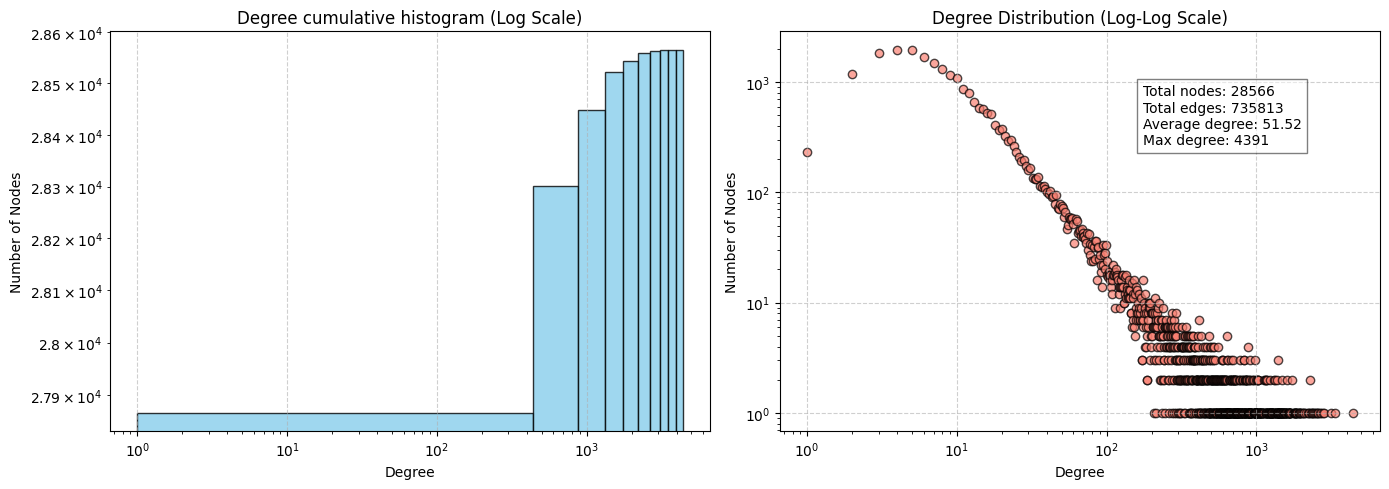

In [49]:
import matplotlib.pyplot as plt
import numpy as np

degrees = sorted(mergegraph.degree())
unique_degrees, counts = np.unique(degrees, return_counts=True)
dmax = max(degrees)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale histogram
ax1.hist(degrees, color='skyblue', edgecolor='black', alpha=0.8,cumulative=True)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Degree cumulative histogram (Log Scale)")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Number of Nodes")
ax1.grid(True, linestyle='--', alpha=0.6)

# Log-log scale plot
ax2.scatter(unique_degrees, counts, color='salmon', alpha=0.7, edgecolor='black')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Degree Distribution (Log-Log Scale)")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Number of Nodes")
ax2.grid(True, linestyle='--', alpha=0.6)

# Add statistics
stats_text = (
    f"Total nodes: {len(mergegraph.vs)}\n"
    f"Total edges: {len(mergegraph.es)}\n"
    f"Average degree: {np.mean(degrees):.2f}\n"
    f"Max degree: {dmax}"
)
plt.figtext(0.82, 0.70, stats_text, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()



Lets now see its components:

In [39]:
#get components
components = mergegraph.connected_components(mode='weak')
LCC = components.subgraph(0)
print(f"Number of components:{len(components)}\n")
print("Info about the Largest Conected Component")
print("")
print(f"Number of nodes in the LCC:{len(LCC.vs)}")
print(f"Number of edges in the LCC:{len(LCC.es)}")

Number of components:8

Info about the Largest Conected Component

Number of nodes in the LCC:28548
Number of edges in the LCC:735797


Since the largest conected component is almost the same size of the whole graph (28548 from 28566) we'll consider only this component and regard this graph as conected for now on. Also, we have a very skewed distribuition of the centrality (degree centrality) of the nodes in the network. Other forms of centrality are found, however, to be more meaningful in the study of cognitive networks, we should check for the most closer central nodes:

In [40]:
#get the closeness centrality for each node
LCC.vs['closeness'] = LCC.closeness()

In [41]:
#Store the values of centrality
nodes_data = []
for v in LCC.vs:
    nodes_data.append({
        'Node': v['name'] if 'name' in v.attributes() else str(v.index),
        'Closeness Centrality': v['closeness']
    })

In [43]:
# Create DataFrame and sort
df = pd.DataFrame(nodes_data)
df = df.sort_values('Closeness Centrality', ascending=False)
print(df.head(10).to_string(index=False))

      Node  Closeness Centrality
    social              0.519169
 political              0.515847
      base              0.511009
   article              0.501123
        it              0.497898
    debate              0.495401
    crisis              0.492419
  analysis              0.491706
   examine              0.491469
government              0.491080


As expected the most central words to all documents were all political (social, debate, crisis, goverment) and analisys (examine) related terms (apart from the stopword it), that is a good indicative that our dataset general theme has been captured by the model of TFMN. Now we expect that, as we narrow down our group of texts, the TFMN will be able to highlight the most central concepts shared by the texts in the frame of analisys, that is, we expect that the TFMN captures concepts more context related reflecting the particular ways in which different groups build their research narratives.

Let's check for the valence around this words in the network, for that we use again the EmoAtlas Library:

In [3]:
!pip install git+https://github.com/MassimoStel/emoatlas

  Cloning https://github.com/MassimoStel/emoatlas to /tmp/pip-req-build-nh_td6_w
  Running command git clone --filter=blob:none --quiet https://github.com/MassimoStel/emoatlas /tmp/pip-req-build-nh_td6_w
  Resolved https://github.com/MassimoStel/emoatlas to commit 7856656405bc96324a2a377e1450cc3f4e689216
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.6 MB/s eta 0:00:00
  Created wheel for emoatlas: filename=emoatlas-0.2.0-py3-none-any.whl size=3766152 sha256=2b2880cceef248e551ebb69a6c689e463dd3c93c0a8a2fe5c1fe484586f46dc0
  Stored in directory: /tmp/pip-ephem-wheel-cache-2gbi47ax/wheels/f8/1e/54/1b9f3fd74b7906f753c3ee64aede89fd138b802bb33257d9bf
Successfully built emoatlas


In [4]:
!python -m spacy download en_core_web_lg
import nltk
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Importing packages
from emoatlas import EmoScores
import pandas as pd
import os
import json

emos = EmoScores()
fmnt = emos.nxgraph_to_formamentis(merged_graph)

Let's see how is the word government framed:

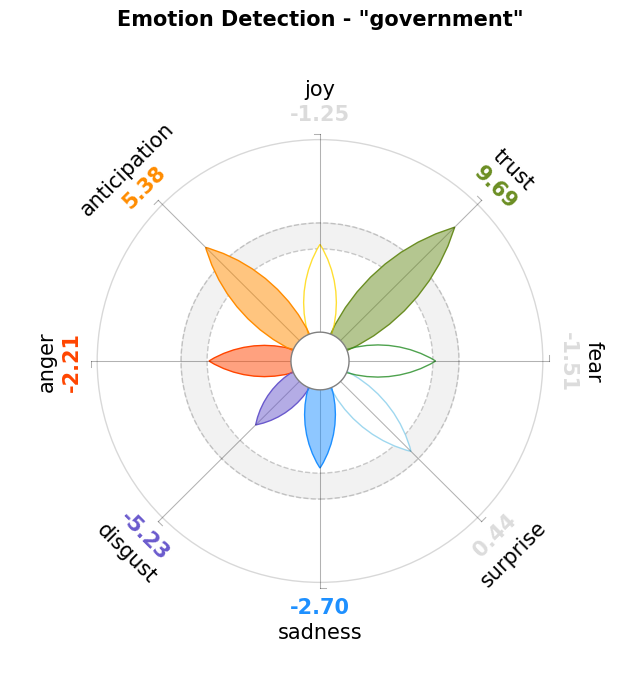

In [7]:
# Displaying a single word
fmnt_you = emos.extract_word_from_formamentis(fmnt, 'government')
emos.draw_statistically_significant_emotions(fmnt_you, title = 'Emotion Detection - \"government\"')

 The most predominant emotion we find surrounding the concept "government" in our network is trust, meaning that in most of the works the government is related to trustfulness. Now, lets perform a sanity check and see if the selected most central words for one particular work differ from the selected words from the agreggate of all works, for this the work choosen is "Fighting for the True Path of Revolution: The Communist Party of El Salvador (PCS) during the Sixties", the abstract is:

In [ ]:
abstract = df["Abstract"].iloc[0]
print(abstract)

The Salvadoran Communist Party (PCS) underwent great internal tensions throughout the 1960s, which led to its fracture at the end of the decade. Conventionally, these tensions have been explained as the result of internal differences related to the party’s position on the armed struggle. In contrast, this article shows that the internal dynamics of the party in this period can be explained by a series of disputes with a strong class component, which involved the two factions competing for the leadership of the organization. On the one hand, there was a workers’ faction in favor of proletarianizing the leadership of the party and deepening the class struggle through the work of the trade unions, and on the other, a sector of intellectuals that supported the political-electoral struggle, with the prospect of gradually accumulating forces. The reversal of the liberalization process experienced under the Salvadoran authoritarian regime since the early sixties, together with the party’s pos

Lets see if our forma mentis could capture the most central concepts for this abstract:

In [ ]:
import networkx as nx

test_graph = nx.read_graphml("/content/drive/MyDrive/Material_IC/Corpus/Artigos/TFMN_simple/10.1177_0094582x241300288_edges_list.graphml")

top_nodes_table2= top_central_nodes(test_graph)
print(top_nodes_table2.to_markdown(index=False))

| Node           |   Closeness Centrality |   Neighbors |
|:---------------|-----------------------:|------------:|
| party          |               0.507812 |          17 |
| position       |               0.485075 |          11 |
| struggle       |               0.477941 |          14 |
| leadership     |               0.471014 |          10 |
| internal       |               0.448276 |          15 |
| lead           |               0.442177 |          12 |
| organization   |               0.422078 |           7 |
| proletarianize |               0.422078 |           7 |
| relate         |               0.414013 |           6 |
| explain        |               0.403727 |          10 |


As we see, when we compare our results with the previuos concepts highlighted by the general forma mentis we see that the most centered concepts for this particular forma mentis are all related to the process of erosion of the party. Using forma mentis we can also see how those concepts are framed in the text:

In [ ]:
neighbors = list(test_graph.neighbors("party"))
print(neighbors)

['position', 'undergo', 'pc', 'communist', 'struggle', 'leadership', 'war', 'great', 'internal', 'salvadoran', 'tension', 'relate', 'dynamic', 'explain', 'proletarianize', 'experience', 'organization']


We point out the word "proletarianize" conected to "party" giving a hint of the particular way in which the article will deal with the process of dissolution of the party.